In [1]:
!pip install rioxarray rasterio pystac_client planetary_computer odc.stac

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.2/62.2 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 62.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.8/41.8 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 155.1/155.1 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 206.8/206.8 kB 10.4 MB/s eta 0:00:00


In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
import warnings 
warnings.filterwarnings('ignore')

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import xarray as xr
import matplotlib.pyplot as plt
import rioxarray as rio
import rasterio
from tqdm import tqdm
import pystac_client 
import planetary_computer
from odc.stac import stac_load

plt.rcParams['figure.figsize'] = (10,8)
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [3]:
# bounding box for new york city( latitude and longitude)

# lower_left = (40.75, -74.01)
# upper_right = (40.88, -73.86)

# bounding box for fergana (uzbekistan)
lower_left  = (40.15, 70.75)        # (lat, lon)
upper_right = (40.55, 71.75)
bounds = (lower_left[1], lower_left[0], upper_right[1], upper_right[0])
time_window = "2021-07-01/2021-07-31"

In [4]:
stac = pystac_client.Client.open('https://planetarycomputer.microsoft.com/api/stac/v1')
search = stac.search(
    bbox=bounds,
    datetime=time_window,
    collections=['sentinel-2-l2a'],
    query={'eo:cloud_cover': {'lt': 25}},
)

In [5]:
items = list(search.get_items())
print(f'Number of Sentinel-2 scenes found :{len(items)}')
signed_items = [planetary_computer.sign(item) for item in items]

Number of Sentinel-2 scenes found :41


In [6]:
bands = ['B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B8A', 'B11', 'B12', 'SCL', 'WVP', 'AOT']
resolution = 10/111320.0

In [7]:
data = stac_load(
    items,
    bands=bands,
    crs='EPSG:4326',
    resolution=resolution,
    chunks={'x':2048, 'y':2048},
    dtype='uint16',
    patch_url = planetary_computer.sign,
    bbox=bounds,
)


In [8]:
unique_dates = data.time.dt.date.drop_duplicates("time")
print("Unique dates:", unique_dates.size)

first_per_day = data.groupby("time.date").first()
data = first_per_day.rename(date="time") 

Unique dates: 8


In [9]:
print(data.time.size)

8


In [10]:
# valid_ratio = (data[["B04","B03","B02"]] > 0).all(dim="time").mean(dim=("longitude","latitude"))
# data = data.where(valid_ratio > 0.05, drop=True)

# valid_mask = (data["B04"] > 0)  # True where valid, False where black/missing

# # Step 2: Compute % valid pixels per time slice
# valid_ratio = valid_mask.mean(dim=("longitude", "latitude"))

# # Step 3: Keep only scenes with ≥95% valid pixels
# data = data.where(valid_ratio >= 0.95, drop=True)

rgb = data[["B04","B03","B02"]].to_array(dim="band")
scene_ok = (rgb > 0).all("band").mean(("longitude", "latitude"))
mask = scene_ok.compute() >= 0.8   # <- .compute() turns it into a numpy bool array
data = data.isel(time=mask)
print(f"Remaining scenes: {data.time.size}")

Remaining scenes: 2


In [11]:
n_scenes = len(data["time"])
print("Scenes left after filter:", n_scenes)

Scenes left after filter: 2


In [12]:
# data = data.persist()
# print(data)
display(data)

<xarray.Dataset> Size: 3GB
Dimensions:      (time: 2, latitude: 4454, longitude: 11132)
Coordinates:
  * latitude     (latitude) float64 36kB 40.55 40.55 40.55 ... 40.15 40.15 40.15
  * longitude    (longitude) float64 89kB 70.75 70.75 70.75 ... 71.75 71.75
    spatial_ref  int32 4B 4326
  * time         (time) object 16B 2021-07-25 2021-07-30
Data variables: (12/14)
    B01          (time, latitude, longitude) uint16 198MB dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    B02          (time, latitude, longitude) uint16 198MB dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    B03          (time, latitude, longitude) uint16 198MB dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    B04          (time, latitude, longitude) uint16 198MB dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    B05          (time, latitude, longitude) uint16 198MB dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    B06          (time, latitude, longitude) uint16 198MB dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    ...           ...
    B8A          (time, latitude, longitude) uint16 198MB dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    B11          (time, latitude, longitude) uint16 198MB dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    B12          (time, latitude, longitude) uint16 198MB dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    SCL          (time, latitude, longitude) uint16 198MB dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    WVP          (time, latitude, longitude) uint16 198MB dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    AOT          (time, latitude, longitude) uint16 198MB dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>

In [13]:
# for band in bands:
#     data.isel(time=0)[band].plot.imshow(cmap='viridis', robust=True)
#     plt.title(f"{band} Band")
#     plt.axis('off')
#     plt.show()

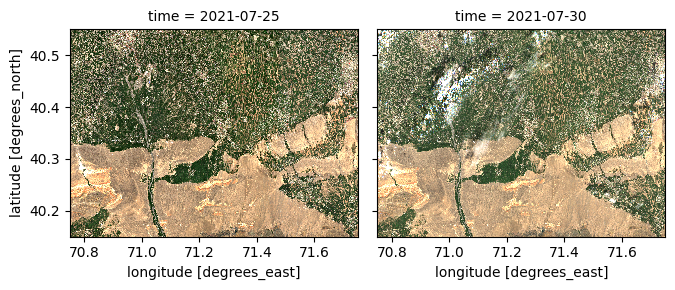

In [14]:
plot_data = data[["B04","B03","B02"]].to_array()
plot_data.plot.imshow(col='time', col_wrap=4, robust=True, vmin=0, vmax=2500)
plt.show()
# rgb = data[["B04","B03","B02"]].to_array(dim="band")
# rgb = rgb.transpose("time", "latitude", "longitude", "band")
# anim = rgb.plot.imshow(col="time", robust=True, vmin=0, vmax=2500).animate()
# from matplotlib import rc
# rc('animation', html='jshtml')
# anim

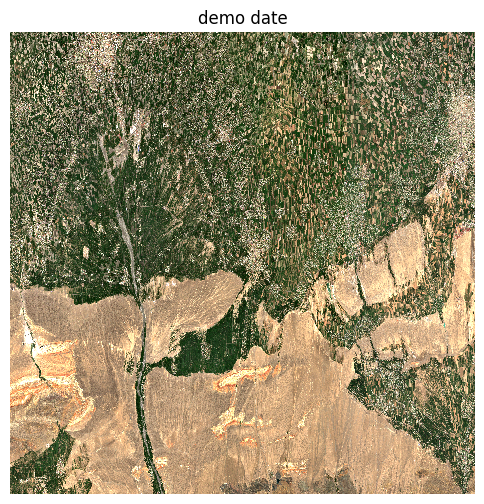

In [15]:
fig, ax = plt.subplots(figsize=(6,6))
plot_data.isel(time=0).plot.imshow(robust=True, ax=ax, vmin=0, vmax=2500)
ax.set_title("demo date")
ax.axis('off')
plt.show()

In [16]:
# median = data.median(dim='time').compute()

In [17]:
# fig, ax = plt.subplots(figsize=(6,6))
# median[["B04", "B03", "B02"]].to_array().plot.imshow(robust=True, ax=ax, vmin=0, vmax=2500)
# ax.set_title("RGB Median Composite")
# ax.axis('off')
# plt.show()

In [18]:
# ndvi_median = (median.B08 - median.B04) / (median.B08 + median.B04)
# # nvdi = nvdi.persist()
# ndbi_median = (median.B11 - median.B08) / (median.B11 + median.B08)
# ndwi_median = (median.B03 - median.B08) / (median.B03 + median.B08)

**Enhanced Vegetation Index(EVI)**

**Soil-Adjusted Vegetation Index(SAVI)**

**Modified Soil_Adjusted Vegetation Inde(MSAVI)**

**Green Normalized Difference Vegetation Index (GNDVI)**

**Index-Based Built-Up Index(IBI)**

**Urban Index(UI)**

**Normalized Difference Bare Soil Index(NDSI)**

**Normalized Difference Moisture 
Index(NDMI)**

**Normalized Difference Snow Index(NDSI)**

**Brightness Index(BI)**



# Weighted Mosaicing

In [19]:
# Weighted Temporal Mosaicking
# Assign weights based on cloud-free pixels (cloud mask using SCL band)
# weights = ~((data["SCL"] == 8) | (data["SCL"] == 9) | (data["SCL"] == 10) | (data["SCL"] == 11))

# # Calculate weighted mosaic
# weighted_mosaic = {}
# for band in data.data_vars.keys():
#     # if band != "SCL":  
#       weighted_mosaic[band] = (data[band] * weights).sum(dim="time") / weights.sum(dim="time")

scene = data.isel(time=0)          # or .sel(time='2023-07-25')

# 2. feed it straight into "weighted_mosaic" dict
weighted_mosaic = {band: scene[band] for band in scene.data_vars}

# Convert the weighted mosaic to an Xarray dataset
weighted_mosaic_data = xr.Dataset(weighted_mosaic)

for var in weighted_mosaic_data.data_vars:
    weighted_mosaic_data[var] = weighted_mosaic_data[var].astype("float32")

def apply_sentinel2_scaling(ds):
    """
    Applies scaling factor to Sentinel-2 reflectance bands.

    Parameters:
    - ds : xarray.Dataset
        Sentinel-2 dataset with reflectance bands.

    Returns:
    - xarray.Dataset
        Scaled Sentinel-2 dataset.
    """
    # Sentinel-2 L2A surface reflectance scaling factor
    scaling_factor = 0.0001
    
    reflectance_bands = ['B01', 'B02', 'B03', 'B04', 'B05', 
                        'B06', 'B07', 'B08', 'B8A', 'B11', 'B12']
    
    for band in reflectance_bands:
        if band in ds.data_vars:
            ds[band] = ds[band].astype(float) * scaling_factor
        else:
            print(f"Warning: Band {band} not found in the dataset.")
    
    return ds

weighted_mosaic_data = apply_sentinel2_scaling(weighted_mosaic_data)

# Add derived indices to the weighted mosaic
# weighted_mosaic_data["NDVI"] = (weighted_mosaic_data.B08 - weighted_mosaic_data.B04) / (weighted_mosaic_data.B08 + weighted_mosaic_data.B04)
# weighted_mosaic_data["NDBI"] = (weighted_mosaic_data.B11 - weighted_mosaic_data.B08) / (weighted_mosaic_data.B11 + weighted_mosaic_data.B08)
# weighted_mosaic_data["NDWI"] = (weighted_mosaic_data.B03 - weighted_mosaic_data.B08) / (weighted_mosaic_data.B03 + weighted_mosaic_data.B08)
# weighted_mosaic_data["EVI"] = 2.5 * ((weighted_mosaic_data.B08 - weighted_mosaic_data.B04) / (weighted_mosaic_data.B08 + 6 * weighted_mosaic_data.B04 - 7.5 * weighted_mosaic_data.B02 + 1))
# weighted_mosaic_data["SAVI"] = ((weighted_mosaic_data.B08 - weighted_mosaic_data.B04) * 1.5) / (weighted_mosaic_data.B08 + weighted_mosaic_data.B04 + 0.5)
# weighted_mosaic_data["MSAVI"] = (2 * weighted_mosaic_data.B08 + 1 - ((2 * weighted_mosaic_data.B08 + 1) ** 2 - 8 * (weighted_mosaic_data.B08 - weighted_mosaic_data.B04)) ** 0.5) / 2
# weighted_mosaic_data["GNDVI"] = (weighted_mosaic_data.B08 - weighted_mosaic_data.B03) / (weighted_mosaic_data.B08 + weighted_mosaic_data.B03)
# weighted_mosaic_data["IBI"] = (2 * weighted_mosaic_data.B11 - (weighted_mosaic_data.B08 + weighted_mosaic_data.B04)) / (weighted_mosaic_data.B11 + weighted_mosaic_data.B08 + weighted_mosaic_data.B04)
# weighted_mosaic_data["UI"] = (weighted_mosaic_data.B08 + weighted_mosaic_data.B11) / (weighted_mosaic_data.B02 + weighted_mosaic_data.B03)
# weighted_mosaic_data["NDBSI"] = (weighted_mosaic_data.B03 + weighted_mosaic_data.B11) / (weighted_mosaic_data.B08 + weighted_mosaic_data.B02)
# weighted_mosaic_data["NDMI"] = (weighted_mosaic_data.B08 - weighted_mosaic_data.B11) / (weighted_mosaic_data.B08 + weighted_mosaic_data.B11)
# weighted_mosaic_data["NDSI"] = (weighted_mosaic_data.B03 - weighted_mosaic_data.B11) / (weighted_mosaic_data.B03 + weighted_mosaic_data.B11)
# weighted_mosaic_data["BI"] = (weighted_mosaic_data.B03 + weighted_mosaic_data.B04 + weighted_mosaic_data.B08 + weighted_mosaic_data.B11) / 4

# # Add new features
# weighted_mosaic_data["REP"] = 705 + 35 * (((weighted_mosaic_data.B05 + weighted_mosaic_data.B07) / 2) - weighted_mosaic_data.B06) / (weighted_mosaic_data.B07 - weighted_mosaic_data.B05)
# weighted_mosaic_data["NGRDI"] = (weighted_mosaic_data.B03 - weighted_mosaic_data.B04) / (weighted_mosaic_data.B03 + weighted_mosaic_data.B04)
# weighted_mosaic_data["MNDWI"] = (weighted_mosaic_data.B03 - weighted_mosaic_data.B11) / (weighted_mosaic_data.B03 + weighted_mosaic_data.B11)
# weighted_mosaic_data["NDWI_Variant"] = (weighted_mosaic_data.B03 - weighted_mosaic_data.B8A) / (weighted_mosaic_data.B03 + weighted_mosaic_data.B8A)
# weighted_mosaic_data["BSI"] = (weighted_mosaic_data.B11 + weighted_mosaic_data.B04 - weighted_mosaic_data.B08 - weighted_mosaic_data.B02) / (weighted_mosaic_data.B11 + weighted_mosaic_data.B04 + weighted_mosaic_data.B08 + weighted_mosaic_data.B02)
# weighted_mosaic_data["SBI"] = ((weighted_mosaic_data.B03 ** 2 + weighted_mosaic_data.B04 ** 2 + weighted_mosaic_data.B11 ** 2) ** 0.5)
# weighted_mosaic_data["Albedo"] = (weighted_mosaic_data.B02 + weighted_mosaic_data.B03 + weighted_mosaic_data.B04 + weighted_mosaic_data.B8A + weighted_mosaic_data.B11) / 5
# weighted_mosaic_data["Vegetation_Ratio"] = ((weighted_mosaic_data["SCL"] == 4).sum(dim=["latitude", "longitude"]) / weighted_mosaic_data["SCL"].size) * 100
# weighted_mosaic_data["Bare_Soil_Ratio"] = ((weighted_mosaic_data["SCL"] == 5).sum(dim=["latitude", "longitude"]) / weighted_mosaic_data["SCL"].size) * 100
# weighted_mosaic_data["Water_Ratio"] = ((weighted_mosaic_data["SCL"] == 6).sum(dim=["latitude", "longitude"]) / weighted_mosaic_data["SCL"].size) * 100

# # Simplified binary masks
# weighted_mosaic_data["Urban_Ratio"] = ((weighted_mosaic_data["SCL"] == 5).sum(dim=["latitude", "longitude"]) / weighted_mosaic_data["SCL"].size) * 100
# weighted_mosaic_data["Cloud_Shadow_Ratio"] = ((weighted_mosaic_data["SCL"] == 3).sum(dim=["latitude", "longitude"]) / weighted_mosaic_data["SCL"].size) * 100
# Save weighted mosaic to GeoTIFF
weighted_mosaic_tiff_path = "Sentinel2_WeightedMosaic_All_Bands_and_Indices.tiff"
weighted_mosaic_data.rio.to_raster(weighted_mosaic_tiff_path, compress="lzw")
print(f"Weighted mosaic GeoTIFF with all features saved at {weighted_mosaic_tiff_path}")


Weighted mosaic GeoTIFF with all features saved at Sentinel2_WeightedMosaic_All_Bands_and_Indices.tiff


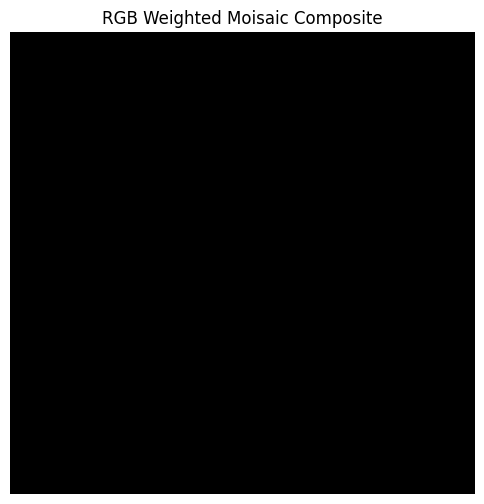

In [20]:
fig, ax = plt.subplots(figsize=(6,6))
weighted_mosaic_data[["B04", "B03", "B02"]].to_array().plot.imshow(robust=True, ax=ax, vmin=0, vmax=2500)
ax.set_title("RGB Weighted Moisaic Composite")
ax.axis('off')
plt.show()

In [21]:
import rioxarray
from rasterio.enums import Resampling
import numpy as np
import os
import xarray as xr

# def save_resampled_weighted_mosaics(
#     ds,
#     target_resolution=30,
#     methods=['bilinear', 'cubic'],
#     output_prefix='WeightedMosaic_30m'
# ):
#     """
#     Resamples the weighted mosaic dataset to a specified resolution using multiple interpolation methods
#     and saves each resampled dataset as a separate GeoTIFF file.
#     Also prints per-band NaN statistics for diagnostic purposes.
    
#     Parameters
#     ----------
#     ds : xarray.Dataset
#         The weighted mosaic dataset.
#     target_resolution : float, optional
#         Desired output resolution in meters (default=30).
#     methods : list of str, optional
#         Interpolation methods to apply (default=['bilinear', 'cubic']).
#     output_prefix : str, optional
#         Prefix for output filenames (default='WeightedMosaic_30m').
#     """
    
#     resampling_methods = {
#         'bilinear': Resampling.bilinear,
#         'cubic': Resampling.cubic
#     }
#     target_crs = "EPSG:4326"  # UTM Zone 18N for NYC
    
#     # ----------------------------------------------------------------
#     # 1) Set CRS correctly
#     # ----------------------------------------------------------------
#     if not ds.rio.crs:
#         ds = ds.rio.write_crs("EPSG:4326")
#         print("CRS set to EPSG:4326.")
#     else:
#         print(f"Existing CRS: {ds.rio.crs}")
    
#     # ----------------------------------------------------------------
#     # 2) Rename dimensions if necessary
#     # ----------------------------------------------------------------
#     if 'latitude' in ds.dims and 'longitude' in ds.dims:
#         ds = ds.rename({'latitude': 'y', 'longitude': 'x'})
#         print("Renamed (latitude->y, longitude->x) for spatial dims.")
    
#     # ----------------------------------------------------------------
#     # 3) Resample each method
#     # ----------------------------------------------------------------
#     for method in methods:
#         if method not in resampling_methods:
#             print(f"Skipping invalid method: {method}")
#             continue

#         print(f"\n--- Processing {method.upper()} resampling ---")
        
#         try:
#             # Identify 2D spatial variables
#             spatial_vars = [var for var in ds.data_vars if ds[var].ndim == 2]
#             ds_filtered = ds[spatial_vars]
            
#             processed_vars = {}
#             for var_name in spatial_vars:
#                 da = ds_filtered[var_name].astype(np.float32)
                
#                 # Reproject to target CRS without setting nodata
#                 da_reproj = da.rio.reproject(
#                     dst_crs=target_crs,              # Correct keyword argument
#                     resolution=target_resolution,
#                     resampling=resampling_methods[method],
#                     nodata=None                       # Do not set nodata
#                 )
#                 processed_vars[var_name] = da_reproj
            
#             # Rebuild dataset
#             ds_reproj = xr.Dataset(processed_vars)
            
#             # Print NaN statistics
#             print("NaN Stats (after resampling) for each variable:")
#             for var_name in spatial_vars:
#                 da_ = ds_reproj[var_name]
#                 nan_count = da_.isnull().sum().compute().item()
#                 total_count = da_.size
#                 min_val = da_.min().compute().item()
#                 max_val = da_.max().compute().item()
#                 nan_percentage = (nan_count / total_count) * 100
#                 print(f"  {var_name}: NaNs={nan_count}/{total_count} ({nan_percentage:.2f}%), Min={min_val:.4f}, Max={max_val:.4f}")
            
#             # Define output path
#             output_path = f"{output_prefix}_{method}.tiff"
#             os.makedirs(os.path.dirname(output_prefix), exist_ok=True)
            
#             # Save to GeoTIFF without nodata
#             ds_reproj[spatial_vars].rio.to_raster(
#                 output_path,
#                 dtype="float32",
#                 compress="LZW",
#                 tiled=True,
#                 nodata=None
#             )
            
#             print(f"✅ Saved resampled mosaic: {output_path}")
#             print(f"Output dimensions: {ds_reproj.dims}")
        
#         except Exception as e:
#             print(f"❌ Error in {method} processing: {str(e)}")
#             continue


# # Usage with your dataset:
# save_resampled_weighted_mosaics(weighted_mosaic_data, output_prefix='/kaggle/working/Sentinel2_Mosaic_bands_sampled')

In [22]:
from rasterio.transform import from_bounds
def resample_to_30m(ds, method="bilinear"):
    """
    Resamples Sentinel data from ~10m to ~30m (1/3 the resolution),
    using bilinear or cubic interpolation, 
    while preserving the 'latitude' and 'longitude' dimension names in the output.

    Parameters:
    - ds : xarray.Dataset
        Sentinel dataset to resample (dims: 'time', 'latitude', 'longitude').
    - method : str
        Interpolation method ('bilinear' or 'cubic').

    Returns:
    - xarray.Dataset
        Resampled dataset with lat/lon dimension names restored.
    """
    print(f"Resampling data to ~30m using {method} interpolation...")

    # Define resampling methods
    resampling_methods = {
        "bilinear": Resampling.bilinear,
        "cubic": Resampling.cubic
    }
    if method not in resampling_methods:
        raise ValueError("Invalid method. Choose 'bilinear' or 'cubic'.")

    # Store original lat/lon range
    min_lat = float(ds.latitude.min().values)
    max_lat = float(ds.latitude.max().values)
    min_lon = float(ds.longitude.min().values)
    max_lon = float(ds.longitude.max().values)

    # Temporarily rename dims from (latitude, longitude) -> (y, x)
    ds_renamed = ds.rename_dims({"latitude": "y", "longitude": "x"})
    ds_renamed = ds_renamed.rename_vars({"latitude": "y", "longitude": "x"})

    # Let rioxarray know these are spatial dims in EPSG:4326
    ds_renamed = ds_renamed.rio.write_crs("EPSG:4326", inplace=False)
    ds_renamed = ds_renamed.rio.set_spatial_dims(x_dim="x", y_dim="y", inplace=False)

    # Determine new shape (1/3 factor → integer downsampling)
    # e.g., if original ~10m, new ~30m => shape is 1/3 the original size
    new_height = ds.sizes["latitude"] // 3
    new_width  = ds.sizes["longitude"] // 3

    # Reproject/resample with the new shape
    resampled_ds = ds_renamed.rio.reproject(
        ds_renamed.rio.crs,
        resampling=resampling_methods[method],
        shape=(new_height, new_width)
    )

    # Create new lat/lon arrays
    new_lat = np.linspace(min_lat, max_lat, new_height)
    new_lon = np.linspace(min_lon, max_lon, new_width)

    # Assign these as coords on y/x
    resampled_ds = resampled_ds.assign_coords(y=("y", new_lat), x=("x", new_lon))

    # Rename dims/vars back to (latitude, longitude)
    resampled_ds = resampled_ds.rename_dims({"y": "latitude", "x": "longitude"})
    resampled_ds = resampled_ds.rename_vars({"y": "latitude", "x": "longitude"})

    # Mark them again as the spatial dims
    resampled_ds = resampled_ds.rio.set_spatial_dims(
        x_dim="longitude", y_dim="latitude", inplace=False
    )

    print("✅ Resampling completed with coordinates restored.")
    return resampled_ds

def save_mosaic_to_tiff(ds, output_path, bounds):
    """
    Saves an xarray.Dataset (with dims "latitude" and "longitude") 
    to a multi-band GeoTIFF, using a bounding box transform.

    Parameters:
    - ds : xarray.Dataset with .rio CRS = EPSG:4326
    - output_path : str, path to save the GeoTIFF
    - bounds : tuple (min_lon, min_lat, max_lon, max_lat)
    """
    os.makedirs(os.path.dirname(output_path), exist_ok=True)

    # Identify spatial variables: 2D variables
    spatial_vars = [var for var in ds.data_vars if ds[var].ndim == 2]

    if not spatial_vars:
        print("❌ No 2D spatial variables found to save.")
        return

    # Ensure all spatial_vars have the same shape
    shapes = {ds[var].shape for var in spatial_vars}
    if len(shapes) != 1:
        print("❌ Not all spatial variables have the same shape.")
        for var in spatial_vars:
            print(f"{var}: shape={ds[var].shape}")
        return

    # Rasterio transform, using # of pixels from ds and bounding box from 'bounds'
    width = ds.sizes["longitude"]
    height = ds.sizes["latitude"]
    transform = from_bounds(bounds[0], bounds[1], bounds[2], bounds[3], width, height)

    # Stack spatial_vars into (count, height, width)
    band_stack = np.stack([ds[var].values for var in spatial_vars])

    print(f"Saving {len(spatial_vars)}-band GeoTIFF at: {output_path}")
    with rasterio.open(
        output_path,
        "w",
        driver="GTiff",
        height=height,
        width=width,
        count=len(spatial_vars),
        dtype="float32",
        crs="EPSG:4326",
        transform=transform,
        compress="lzw"
    ) as dst:
        for i, var_name in enumerate(spatial_vars, start=1):
            dst.write(band_stack[i - 1], i)
            dst.set_band_description(i, var_name)

    print(f"✅ Successfully saved: {output_path}")

    # Print NaN statistics
    print("NaN Stats for each band:")
    for var_name in spatial_vars:
        da = ds[var_name]
        nan_count = np.isnan(da.values).sum()
        total_count = da.size
        nan_percentage = (nan_count / total_count) * 100
        min_val = np.nanmin(da.values)
        max_val = np.nanmax(da.values)
        print(f"  {var_name}: NaNs={nan_count}/{total_count} ({nan_percentage:.2f}%), Min={min_val:.4f}, Max={max_val:.4f}")
def verify_output_tiff(tiff_path):
    """
    Simple helper to check the existence and some metadata
    of the output GeoTIFF file.
    """
    try:
        tiff_path = os.path.abspath(tiff_path)
        if not os.path.exists(tiff_path):
            print(f"Error: File not found at {tiff_path}")
            return False

        print(f"\nVerifying file at: {tiff_path}")
        with rasterio.open(tiff_path) as src:
            print(f"CRS: {src.crs}")
            print(f"Transform: {src.transform}")
            print(f"Bounds: {src.bounds}")
            file_mb = os.path.getsize(tiff_path)/(1024*1024)
            print(f"File size: {file_mb:.2f} MB")

        return True
    except Exception as e:
        print(f"❌ Error verifying TIFF: {e}")
        return False
resampled_30m_ds = resample_to_30m(weighted_mosaic_data, method="bilinear")
save_mosaic_to_tiff(resampled_30m_ds, "/kaggle/working/sentinel_30m_billinear.tiff", bounds)

Resampling data to ~30m using bilinear interpolation...
✅ Resampling completed with coordinates restored.
Saving 14-band GeoTIFF at: /kaggle/working/sentinel_30m_billinear.tiff
✅ Successfully saved: /kaggle/working/sentinel_30m_billinear.tiff
NaN Stats for each band:
  B01: NaNs=0/5505640 (0.00%), Min=0.0001, Max=1.0822
  B02: NaNs=0/5505640 (0.00%), Min=0.0001, Max=1.8494
  B03: NaNs=0/5505640 (0.00%), Min=0.0009, Max=1.7802
  B04: NaNs=0/5505640 (0.00%), Min=0.0001, Max=1.7188
  B05: NaNs=0/5505640 (0.00%), Min=0.0001, Max=1.6993
  B06: NaNs=0/5505640 (0.00%), Min=0.0001, Max=1.6689
  B07: NaNs=0/5505640 (0.00%), Min=0.0001, Max=1.6520
  B08: NaNs=0/5505640 (0.00%), Min=0.0001, Max=1.6434
  B8A: NaNs=0/5505640 (0.00%), Min=0.0001, Max=1.6339
  B11: NaNs=0/5505640 (0.00%), Min=0.0039, Max=1.4748
  B12: NaNs=0/5505640 (0.00%), Min=0.0077, Max=1.5385
  SCL: NaNs=0/5505640 (0.00%), Min=2.0000, Max=9.0000
  WVP: NaNs=0/5505640 (0.00%), Min=283.1777, Max=3074.8972
  AOT: NaNs=0/5505640 (0.

In [23]:
# resampled_30m_ds = resample_to_30m(weighted_mosaic_data, method="cubic")
# save_mosaic_to_tiff(resampled_30m_ds, "/kaggle/working/sentinel_30m_resampled_cubic.tiff", bounds)

In [24]:
# Weighted Temporal Mosaicking
# Assign weights based on cloud-free pixels (cloud mask using SCL band)
# weights = ~((data["SCL"] == 8) | (data["SCL"] == 9) | (data["SCL"] == 10) | (data["SCL"] == 11))

# # Calculate weighted mosaic
# weighted_mosaic = {}
# for band in data.data_vars.keys():
#     # if band != "SCL":  # Skip the SCL layer
#       weighted_mosaic[band] = (data[band] * weights).sum(dim="time") / weights.sum(dim="time")

# Convert the weighted mosaic to an Xarray dataset
scene = data.isel(time=0)          # or .sel(time='2023-07-25')

# 2. feed it straight into "weighted_mosaic" dict
weighted_mosaic = {band: scene[band] for band in scene.data_vars}

# Convert the weighted mosaic to an Xarray dataset
weighted_mosaic_data = xr.Dataset(weighted_mosaic)

for var in weighted_mosaic_data.data_vars:
    weighted_mosaic_data[var] = weighted_mosaic_data[var].astype("float32")

# Add derived indices to the weighted mosaic
# weighted_mosaic_data["NDVI"] = (weighted_mosaic_data.B08 - weighted_mosaic_data.B04) / (weighted_mosaic_data.B08 + weighted_mosaic_data.B04)
# weighted_mosaic_data["NDBI"] = (weighted_mosaic_data.B11 - weighted_mosaic_data.B08) / (weighted_mosaic_data.B11 + weighted_mosaic_data.B08)
# weighted_mosaic_data["NDWI"] = (weighted_mosaic_data.B03 - weighted_mosaic_data.B08) / (weighted_mosaic_data.B03 + weighted_mosaic_data.B08)
# weighted_mosaic_data["EVI"] = 2.5 * ((weighted_mosaic_data.B08 - weighted_mosaic_data.B04) / (weighted_mosaic_data.B08 + 6 * weighted_mosaic_data.B04 - 7.5 * weighted_mosaic_data.B02 + 1))
# weighted_mosaic_data["SAVI"] = ((weighted_mosaic_data.B08 - weighted_mosaic_data.B04) * 1.5) / (weighted_mosaic_data.B08 + weighted_mosaic_data.B04 + 0.5)
# weighted_mosaic_data["MSAVI"] = (2 * weighted_mosaic_data.B08 + 1 - ((2 * weighted_mosaic_data.B08 + 1) ** 2 - 8 * (weighted_mosaic_data.B08 - weighted_mosaic_data.B04)) ** 0.5) / 2
# weighted_mosaic_data["GNDVI"] = (weighted_mosaic_data.B08 - weighted_mosaic_data.B03) / (weighted_mosaic_data.B08 + weighted_mosaic_data.B03)
# weighted_mosaic_data["IBI"] = (2 * weighted_mosaic_data.B11 - (weighted_mosaic_data.B08 + weighted_mosaic_data.B04)) / (weighted_mosaic_data.B11 + weighted_mosaic_data.B08 + weighted_mosaic_data.B04)
# weighted_mosaic_data["UI"] = (weighted_mosaic_data.B08 + weighted_mosaic_data.B11) / (weighted_mosaic_data.B02 + weighted_mosaic_data.B03)
# weighted_mosaic_data["NDBSI"] = (weighted_mosaic_data.B03 + weighted_mosaic_data.B11) / (weighted_mosaic_data.B08 + weighted_mosaic_data.B02)
# weighted_mosaic_data["NDMI"] = (weighted_mosaic_data.B08 - weighted_mosaic_data.B11) / (weighted_mosaic_data.B08 + weighted_mosaic_data.B11)
# weighted_mosaic_data["NDSI"] = (weighted_mosaic_data.B03 - weighted_mosaic_data.B11) / (weighted_mosaic_data.B03 + weighted_mosaic_data.B11)
# weighted_mosaic_data["BI"] = (weighted_mosaic_data.B03 + weighted_mosaic_data.B04 + weighted_mosaic_data.B08 + weighted_mosaic_data.B11) / 4

# # Add new features
# weighted_mosaic_data["REP"] = 705 + 35 * (((weighted_mosaic_data.B05 + weighted_mosaic_data.B07) / 2) - weighted_mosaic_data.B06) / (weighted_mosaic_data.B07 - weighted_mosaic_data.B05)
# weighted_mosaic_data["NGRDI"] = (weighted_mosaic_data.B03 - weighted_mosaic_data.B04) / (weighted_mosaic_data.B03 + weighted_mosaic_data.B04)
# weighted_mosaic_data["MNDWI"] = (weighted_mosaic_data.B03 - weighted_mosaic_data.B11) / (weighted_mosaic_data.B03 + weighted_mosaic_data.B11)
# weighted_mosaic_data["NDWI_Variant"] = (weighted_mosaic_data.B03 - weighted_mosaic_data.B8A) / (weighted_mosaic_data.B03 + weighted_mosaic_data.B8A)
# weighted_mosaic_data["BSI"] = (weighted_mosaic_data.B11 + weighted_mosaic_data.B04 - weighted_mosaic_data.B08 - weighted_mosaic_data.B02) / (weighted_mosaic_data.B11 + weighted_mosaic_data.B04 + weighted_mosaic_data.B08 + weighted_mosaic_data.B02)
# weighted_mosaic_data["SBI"] = ((weighted_mosaic_data.B03 ** 2 + weighted_mosaic_data.B04 ** 2 + weighted_mosaic_data.B11 ** 2) ** 0.5)
# weighted_mosaic_data["Albedo"] = (weighted_mosaic_data.B02 + weighted_mosaic_data.B03 + weighted_mosaic_data.B04 + weighted_mosaic_data.B8A + weighted_mosaic_data.B11) / 5
# weighted_mosaic_data["Vegetation_Ratio"] = ((weighted_mosaic_data["SCL"] == 4).sum(dim=["latitude", "longitude"]) / weighted_mosaic_data["SCL"].size) * 100
# weighted_mosaic_data["Bare_Soil_Ratio"] = ((weighted_mosaic_data["SCL"] == 5).sum(dim=["latitude", "longitude"]) / weighted_mosaic_data["SCL"].size) * 100
# weighted_mosaic_data["Water_Ratio"] = ((weighted_mosaic_data["SCL"] == 6).sum(dim=["latitude", "longitude"]) / weighted_mosaic_data["SCL"].size) * 100

# # Simplified binary masks
# weighted_mosaic_data["Urban_Ratio"] = ((weighted_mosaic_data["SCL"] == 5).sum(dim=["latitude", "longitude"]) / weighted_mosaic_data["SCL"].size) * 100
# weighted_mosaic_data["Cloud_Shadow_Ratio"] = ((weighted_mosaic_data["SCL"] == 3).sum(dim=["latitude", "longitude"]) / weighted_mosaic_data["SCL"].size) * 100
# Save weighted mosaic to GeoTIFF
weighted_mosaic_tiff_path = "Sentinel2_WeightedMosaic_(nbs).tiff"
weighted_mosaic_data.rio.to_raster(weighted_mosaic_tiff_path, compress="lzw")
print(f"Weighted mosaic GeoTIFF with all features saved at {weighted_mosaic_tiff_path}")

# save_resampled_weighted_mosaics(weighted_mosaic_data, output_prefix='/kaggle/working/Sentinel2_Mosaic_30m_no_base_sampling')

Weighted mosaic GeoTIFF with all features saved at Sentinel2_WeightedMosaic_(nbs).tiff


In [25]:
resampled_30m_ds = resample_to_30m(weighted_mosaic_data, method="bilinear")
save_mosaic_to_tiff(resampled_30m_ds, "/kaggle/working/sentinel_30m_billinear(nbs).tiff", bounds)

resampled_30m_ds = resample_to_30m(weighted_mosaic_data, method="cubic")
save_mosaic_to_tiff(resampled_30m_ds, "/kaggle/working/sentinel_30m_cubic(nbs).tiff", bounds)

Resampling data to ~30m using bilinear interpolation...
✅ Resampling completed with coordinates restored.
Saving 14-band GeoTIFF at: /kaggle/working/sentinel_30m_billinear(nbs).tiff
✅ Successfully saved: /kaggle/working/sentinel_30m_billinear(nbs).tiff
NaN Stats for each band:
  B01: NaNs=0/5505640 (0.00%), Min=1.0000, Max=10822.0596
  B02: NaNs=0/5505640 (0.00%), Min=1.0000, Max=18494.1016
  B03: NaNs=0/5505640 (0.00%), Min=8.5650, Max=17801.7188
  B04: NaNs=0/5505640 (0.00%), Min=1.0000, Max=17187.7910
  B05: NaNs=0/5505640 (0.00%), Min=1.0000, Max=16992.5742
  B06: NaNs=0/5505640 (0.00%), Min=1.0000, Max=16689.4883
  B07: NaNs=0/5505640 (0.00%), Min=1.0000, Max=16519.5117
  B08: NaNs=0/5505640 (0.00%), Min=1.0000, Max=16434.1758
  B8A: NaNs=0/5505640 (0.00%), Min=1.0000, Max=16338.7393
  B11: NaNs=0/5505640 (0.00%), Min=39.2974, Max=14748.3115
  B12: NaNs=0/5505640 (0.00%), Min=77.4811, Max=15385.2520
  SCL: NaNs=0/5505640 (0.00%), Min=2.0000, Max=9.0000
  WVP: NaNs=0/5505640 (0.00%

In [26]:
# evi_median = (2.5 * ((median.B08 - median.B04) / (median.B08 + (6 * median.B04) - (7.5 * median.B02) + 1)))
# L = 0.5  # Soil brightness correction factor
# savi_median = (((median.B08 - median.B04) / (median.B08 + median.B04 + L)) * (1 + L))
# msavi_median = (((2 * median.B08) + 1) - (((2 * median.B08 + 1) ** 2) - (8 * (median.B08 - median.B04))) ** 0.5) / 2
# gndvi_median = ((median.B08 - median.B03) / (median.B08 + median.B03))

# ibi_median = ((ndbi_median - (ndvi_median + ndwi_median)) / (ndbi_median + (ndvi_median + ndwi_median)))

# ui_median = ((median.B11 - median.B08) / (median.B11 + median.B08))
# ndbsi_median = ((ndbi_median + (1 - ndvi_median)) / 2)
# ndmi_median = ((median.B08 - median.B11) / (median.B08 + median.B11))
# ndsi_median = ((median.B03 - median.B11) / (median.B03 + median.B11))
# bi_median = (((median.B04 ** 2) + (median.B03 ** 2) + (median.B02 ** 2)) ** 0.5) / 3


In [27]:
# def plot_all_indices(indices_dict, vmin_vmax_dict, cmap_dict, title_dict):
#     """
#     Plots all indices in subplots using a grid layout.

#     Parameters:
#     indices_dict: dict
#         A dictionary where keys are index names (e.g., 'NDVI') and values are the calculated xarray indices.
#     vmin_vmax_dict: dict
#         A dictionary where keys are index names and values are tuples of (vmin, vmax) for color scale.
#     cmap_dict: dict
#         A dictionary where keys are index names and values are the colormap to use for each index.
#     title_dict: dict
#         A dictionary where keys are index names and values are the title for each plot.
#     """
#     num_indices = len(indices_dict)
#     ncols = 3  # Number of columns in the grid
#     nrows = (num_indices + ncols - 1) // ncols  # Calculate rows needed for the grid

#     fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 5 * nrows))
#     axes = axes.flatten()  # Flatten axes for easier iteration

#     for i, (index_name, index_data) in enumerate(indices_dict.items()):
#         ax = axes[i]
#         index_data.plot.imshow(ax=ax, vmin=vmin_vmax_dict[index_name][0], 
#                                vmax=vmin_vmax_dict[index_name][1], cmap=cmap_dict[index_name])
#         ax.set_title(title_dict[index_name])
#         ax.axis('off')

#     # Hide any unused subplots
#     for j in range(i + 1, len(axes)):
#         fig.delaxes(axes[j])

#     plt.tight_layout()
#     plt.show()

# # Define all indices and their properties
# indices_dict = {
#     "NDVI": ndvi_median,
#     "NDWI": ndwi_median,
#     "NDBI": ndbi_median,
#     "EVI": evi_median,
#     "SAVI": savi_median,
#     "MSAVI": msavi_median,
#     "GNDVI": gndvi_median,
#     "IBI": ibi_median,
#     "UI": ui_median,
#     "NDBSI": ndbsi_median,
#     "NDMI": ndmi_median,
#     "NDSI": ndsi_median,
#     "BI": bi_median,
# }

# # Define vmin and vmax for each index
# vmin_vmax_dict = {
#     "NDVI": (0.0, 1.0),
#     "NDWI": (-0.3, 0.3),
#     "NDBI": (-0.1, 0.1),
#     "EVI": (-1.0, 1.0),
#     "SAVI": (0.0, 1.0),
#     "MSAVI": (0.0, 1.0),
#     "GNDVI": (0.0, 1.0),
#     "IBI": (-1.0, 1.0),
#     "UI": (-1.0, 1.0),
#     "NDBSI": (0.0, 1.0),
#     "NDMI": (-1.0, 1.0),
#     "NDSI": (-1.0, 1.0),
#     "BI": (0.0, 1.0),
# }

# # Define colormaps for each index
# cmap_dict = {
#     "NDVI": "RdYlGn",
#     "NDWI": "RdBu",
#     "NDBI": "jet",
#     "EVI": "RdYlGn",
#     "SAVI": "RdYlGn",
#     "MSAVI": "RdYlGn",
#     "GNDVI": "RdYlGn",
#     "IBI": "coolwarm",
#     "UI": "coolwarm",
#     "NDBSI": "YlOrRd",
#     "NDMI": "PiYG",
#     "NDSI": "BrBG",
#     "BI": "cividis",
# }

# # Define titles for each index
# title_dict = {
#     "NDVI": "Normalized Difference Vegetation Index (NDVI)",
#     "NDWI": "Normalized Difference Water Index (NDWI)",
#     "NDBI": "Normalized Difference Built-Up Index (NDBI)",
#     "EVI": "Enhanced Vegetation Index (EVI)",
#     "SAVI": "Soil-Adjusted Vegetation Index (SAVI)",
#     "MSAVI": "Modified Soil-Adjusted Vegetation Index (MSAVI)",
#     "GNDVI": "Green Normalized Difference Vegetation Index (GNDVI)",
#     "IBI": "Index-Based Built-Up Index (IBI)",
#     "UI": "Urban Index (UI)",
#     "NDBSI": "Normalized Difference Bare Soil Index (NDBSI)",
#     "NDMI": "Normalized Difference Moisture Index (NDMI)",
#     "NDSI": "Normalized Difference Snow Index (NDSI)",
#     "BI": "Brightness Index (BI)",
# }

# # Call the function to plot all indices
# # plot_all_indices(indices_dict, vmin_vmax_dict, cmap_dict, title_dict)

In [28]:
# mean_data = data.mean(dim='time').compute()

# # bands_only_path_mean = "Sentinel2_Mean_Only_Bands.tiff"
# # mean_data.rio.to_raster(bands_only_path_mean, compress="lzw")
# # print(f"Mean GeoTIFF with only bands saved at {bands_only_path_mean}")

# # Add all derived indices directly
# mean_data["NDVI"] = (mean_data.B08 - mean_data.B04) / (mean_data.B08 + mean_data.B04)
# mean_data["NDBI"] = (mean_data.B11 - mean_data.B08) / (mean_data.B11 + mean_data.B08)
# mean_data["NDWI"] = (mean_data.B03 - mean_data.B08) / (mean_data.B03 + mean_data.B08)
# mean_data["EVI"] = 2.5 * ((mean_data.B08 - mean_data.B04) / (mean_data.B08 + 6 * mean_data.B04 - 7.5 * mean_data.B02 + 1))
# mean_data["SAVI"] = ((mean_data.B08 - mean_data.B04) * 1.5) / (mean_data.B08 + mean_data.B04 + 0.5)
# mean_data["MSAVI"] = (2 * mean_data.B08 + 1 - ((2 * mean_data.B08 + 1) ** 2 - 8 * (mean_data.B08 - mean_data.B04)) ** 0.5) / 2
# mean_data["GNDVI"] = (mean_data.B08 - mean_data.B03) / (mean_data.B08 + mean_data.B03)
# mean_data["IBI"] = (2 * mean_data.B11 - (mean_data.B08 + mean_data.B04)) / (mean_data.B11 + mean_data.B08 + mean_data.B04)
# mean_data["UI"] = (mean_data.B08 + mean_data.B11) / (mean_data.B02 + mean_data.B03)
# mean_data["NDBSI"] = (mean_data.B03 + mean_data.B11) / (mean_data.B08 + mean_data.B02)
# mean_data["NDMI"] = (mean_data.B08 - mean_data.B11) / (mean_data.B08 + mean_data.B11)
# mean_data["NDSI"] = (mean_data.B03 - mean_data.B11) / (mean_data.B03 + mean_data.B11)
# mean_data["BI"] = (mean_data.B03 + mean_data.B04 + mean_data.B08 + mean_data.B11) / 4

# mean_data["REP"] = 705 + 35 * (((mean_data.B05 + mean_data.B07) / 2) - mean_data.B06) / (mean_data.B07 - mean_data.B05)
# mean_data["NGRDI"] = (mean_data.B03 - mean_data.B04) / (mean_data.B03 + mean_data.B04)
# mean_data["MNDWI"] = (mean_data.B03 - mean_data.B11) / (mean_data.B03 + mean_data.B11)
# mean_data["NDWI_Variant"] = (mean_data.B03 - mean_data.B8A) / (mean_data.B03 + mean_data.B8A)
# mean_data["BSI"] = (mean_data.B11 + mean_data.B04 - mean_data.B08 - mean_data.B02) / (mean_data.B11 + mean_data.B04 + mean_data.B08 + mean_data.B02)
# mean_data["SBI"] = ((mean_data.B03 ** 2 + mean_data.B04 ** 2 + mean_data.B11 ** 2) ** 0.5)
# mean_data["Albedo"] = (mean_data.B02 + mean_data.B03 + mean_data.B04 + mean_data.B8A + mean_data.B11) / 5

# mean_data["Vegetation_Ratio"] = ((mean_data["SCL"] == 4).sum(dim=["latitude", "longitude"]) / mean_data["SCL"].size) * 100
# mean_data["Bare_Soil_Ratio"] = ((mean_data["SCL"] == 5).sum(dim=["latitude", "longitude"]) / mean_data["SCL"].size) * 100
# mean_data["Water_Ratio"] = ((mean_data["SCL"] == 6).sum(dim=["latitude", "longitude"]) / mean_data["SCL"].size) * 100

# # Simplified binary masks
# mean_data["Urban_Ratio"] = ((mean_data["SCL"] == 5).sum(dim=["latitude", "longitude"]) / mean_data["SCL"].size) * 100
# mean_data["Cloud_Shadow_Ratio"] = ((mean_data["SCL"] == 3).sum(dim=["latitude", "longitude"]) / mean_data["SCL"].size) * 100
# # Save median composite to a GeoTIFF file
# mean_tiff_path = "Sentinel2_Mean_All_Bands_and_Indices.tiff"
# mean_data.rio.to_raster(mean_tiff_path, compress="lzw")
# print(f"Mean GeoTIFF saved at {mean_tiff_path}")


In [29]:
# fig, ax = plt.subplots(figsize=(6,6))
# mean_data[["B04", "B03", "B02"]].to_array().plot.imshow(robust=True, ax=ax, vmin=0, vmax=2500)
# ax.set_title("RGB Mean Composite")
# ax.axis('off')
# plt.show()

In [30]:
# # Save Median Composite GeoTIFF
# # Calculate the median composite
# median_data = data.median(dim="time").compute()

# # Save version with only spectral bands
# # bands_only_path_median = "Sentinel2_Median_Only_Bands.tiff"
# # median_data.rio.to_raster(bands_only_path_median, compress="lzw")
# # print(f"Median GeoTIFF with only bands saved at {bands_only_path_median}")

# # Add all derived indices directly
# median_data["NDVI"] = (median_data.B08 - median_data.B04) / (median_data.B08 + median_data.B04)
# median_data["NDBI"] = (median_data.B11 - median_data.B08) / (median_data.B11 + median_data.B08)
# median_data["NDWI"] = (median_data.B03 - median_data.B08) / (median_data.B03 + median_data.B08)
# median_data["EVI"] = 2.5 * ((median_data.B08 - median_data.B04) / (median_data.B08 + 6 * median_data.B04 - 7.5 * median_data.B02 + 1))
# median_data["SAVI"] = ((median_data.B08 - median_data.B04) * 1.5) / (median_data.B08 + median_data.B04 + 0.5)
# median_data["MSAVI"] = (2 * median_data.B08 + 1 - ((2 * median_data.B08 + 1) ** 2 - 8 * (median_data.B08 - median_data.B04)) ** 0.5) / 2
# median_data["GNDVI"] = (median_data.B08 - median_data.B03) / (median_data.B08 + median_data.B03)
# median_data["IBI"] = (2 * median_data.B11 - (median_data.B08 + median_data.B04)) / (median_data.B11 + median_data.B08 + median_data.B04)
# median_data["UI"] = (median_data.B08 + median_data.B11) / (median_data.B02 + median_data.B03)
# median_data["NDBSI"] = (median_data.B03 + median_data.B11) / (median_data.B08 + median_data.B02)
# median_data["NDMI"] = (median_data.B08 - median_data.B11) / (median_data.B08 + median_data.B11)
# median_data["NDSI"] = (median_data.B03 - median_data.B11) / (median_data.B03 + median_data.B11)
# median_data["BI"] = (median_data.B03 + median_data.B04 + median_data.B08 + median_data.B11) / 4

# median_data["REP"] = 705 + 35 * (((median_data.B05 + median_data.B07) / 2) - median_data.B06) / (median_data.B07 - median_data.B05)
# median_data["NGRDI"] = (median_data.B03 - median_data.B04) / (median_data.B03 + median_data.B04)
# median_data["MNDWI"] = (median_data.B03 - median_data.B11) / (median_data.B03 + median_data.B11)
# median_data["NDWI_Variant"] = (median_data.B03 - median_data.B8A) / (median_data.B03 + median_data.B8A)
# median_data["BSI"] = (median_data.B11 + median_data.B04 - median_data.B08 - median_data.B02) / (median_data.B11 + median_data.B04 + median_data.B08 + median_data.B02)
# median_data["SBI"] = ((median_data.B03 ** 2 + median_data.B04 ** 2 + median_data.B11 ** 2) ** 0.5)
# median_data["Albedo"] = (median_data.B02 + median_data.B03 + median_data.B04 + median_data.B8A + median_data.B11) / 5

# median_data["Vegetation_Ratio"] = ((median_data["SCL"] == 4).sum(dim=["latitude", "longitude"]) / median_data["SCL"].size) * 100
# median_data["Bare_Soil_Ratio"] = ((median_data["SCL"] == 5).sum(dim=["latitude", "longitude"]) / median_data["SCL"].size) * 100
# median_data["Water_Ratio"] = ((median_data["SCL"] == 6).sum(dim=["latitude", "longitude"]) / median_data["SCL"].size) * 100

# # Simplified binary masks
# median_data["Urban_Ratio"] = ((median_data["SCL"] == 5).sum(dim=["latitude", "longitude"]) / median_data["SCL"].size) * 100
# median_data["Cloud_Shadow_Ratio"] = ((median_data["SCL"] == 3).sum(dim=["latitude", "longitude"]) / median_data["SCL"].size) * 100
# # Save median composite to a GeoTIFF file
# median_tiff_path = "Sentinel2_Median_All_Bands_and_Indices.tiff"
# median_data.rio.to_raster(median_tiff_path, compress="lzw")
# print(f"Median GeoTIFF saved at {median_tiff_path}")


In [31]:
# fig, ax = plt.subplots(figsize=(6,6))
# median_data[["B04", "B03", "B02"]].to_array().plot.imshow(robust=True, ax=ax, vmin=0, vmax=2500)
# ax.set_title("RGB Median Composite")
# ax.axis('off')
# plt.show()

In [32]:
# # Save Single-Date GeoTIFF
# # Select the specific date (2021-07-24)
# single_date_index = 6  # Ensure this index corresponds to the correct date
# single_date_data = data.isel(time=single_date_index)

# # Save version with only spectral bands
# # bands_only_path_single = "Sentinel2_SingleDate_Only_Bands.tiff"
# # single_date_data.rio.to_raster(bands_only_path_single, compress="lzw")
# # print(f"Single-date GeoTIFF with only bands saved at {bands_only_path_single}")

# # Add all derived indices directly
# single_date_data["NDVI"] = (single_date_data.B08 - single_date_data.B04) / (single_date_data.B08 + single_date_data.B04)
# single_date_data["NDBI"] = (single_date_data.B11 - single_date_data.B08) / (single_date_data.B11 + single_date_data.B08)
# single_date_data["NDWI"] = (single_date_data.B03 - single_date_data.B08) / (single_date_data.B03 + single_date_data.B08)
# single_date_data["EVI"] = 2.5 * ((single_date_data.B08 - single_date_data.B04) / (single_date_data.B08 + 6 * single_date_data.B04 - 7.5 * single_date_data.B02 + 1))
# single_date_data["SAVI"] = ((single_date_data.B08 - single_date_data.B04) * 1.5) / (single_date_data.B08 + single_date_data.B04 + 0.5)
# single_date_data["MSAVI"] = (2 * single_date_data.B08 + 1 - ((2 * single_date_data.B08 + 1) ** 2 - 8 * (single_date_data.B08 - single_date_data.B04)) ** 0.5) / 2
# single_date_data["GNDVI"] = (single_date_data.B08 - single_date_data.B03) / (single_date_data.B08 + single_date_data.B03)
# single_date_data["IBI"] = (2 * single_date_data.B11 - (single_date_data.B08 + single_date_data.B04)) / (single_date_data.B11 + single_date_data.B08 + single_date_data.B04)
# single_date_data["UI"] = (single_date_data.B08 + single_date_data.B11) / (single_date_data.B02 + single_date_data.B03)
# single_date_data["NDBSI"] = (single_date_data.B03 + single_date_data.B11) / (single_date_data.B08 + single_date_data.B02)
# single_date_data["NDMI"] = (single_date_data.B08 - single_date_data.B11) / (single_date_data.B08 + single_date_data.B11)
# single_date_data["NDSI"] = (single_date_data.B03 - single_date_data.B11) / (single_date_data.B03 + single_date_data.B11)
# single_date_data["BI"] = (single_date_data.B03 + single_date_data.B04 + single_date_data.B08 + single_date_data.B11) / 4
# single_date_data["REP"] = 705 + 35 * (((single_date_data.B05 + single_date_data.B07) / 2) - single_date_data.B06) / (single_date_data.B07 - single_date_data.B05)
# single_date_data["NGRDI"] = (single_date_data.B03 - single_date_data.B04) / (single_date_data.B03 + single_date_data.B04)
# single_date_data["MNDWI"] = (single_date_data.B03 - single_date_data.B11) / (single_date_data.B03 + single_date_data.B11)
# single_date_data["NDWI_Variant"] = (single_date_data.B03 - single_date_data.B8A) / (single_date_data.B03 + single_date_data.B8A)
# single_date_data["BSI"] = (single_date_data.B11 + single_date_data.B04 - single_date_data.B08 - single_date_data.B02) / (single_date_data.B11 + single_date_data.B04 + single_date_data.B08 + single_date_data.B02)
# single_date_data["SBI"] = ((single_date_data.B03 ** 2 + single_date_data.B04 ** 2 + single_date_data.B11 ** 2) ** 0.5)
# single_date_data["Albedo"] = (single_date_data.B02 + single_date_data.B03 + single_date_data.B04 + single_date_data.B8A + single_date_data.B11) / 5
# single_date_data["Vegetation_Ratio"] = ((single_date_data["SCL"] == 4).sum(dim=["latitude", "longitude"]) / single_date_data["SCL"].size) * 100
# single_date_data["Bare_Soil_Ratio"] = ((single_date_data["SCL"] == 5).sum(dim=["latitude", "longitude"]) / single_date_data["SCL"].size) * 100
# single_date_data["Water_Ratio"] = ((single_date_data["SCL"] == 6).sum(dim=["latitude", "longitude"]) / single_date_data["SCL"].size) * 100

# # Simplified binary masks
# single_date_data["Urban_Ratio"] = ((single_date_data["SCL"] == 5).sum(dim=["latitude", "longitude"]) / single_date_data["SCL"].size) * 100
# single_date_data["Cloud_Shadow_Ratio"] = ((single_date_data["SCL"] == 3).sum(dim=["latitude", "longitude"]) / single_date_data["SCL"].size) * 100
# # Save single-date data to a GeoTIFF file
# single_date_tiff_path = "Sentinel2_SingleDate_All_Bands_and_Indices.tiff"
# single_date_data.rio.to_raster(single_date_tiff_path, compress="lzw")
# print(f"Single-date GeoTIFF saved at {single_date_tiff_path}")


In [33]:
# fig, ax = plt.subplots(figsize=(6,6))
# single_date_data[["B04", "B03", "B02"]].to_array().plot.imshow(robust=True, ax=ax, vmin=0, vmax=2500)
# ax.set_title("RGB Single date(24-July-2024) Composite")
# ax.axis('off')
# plt.show()

In [34]:
# from tqdm import tqdm

# # Select the specific date (2021-07-24)
# single_date_masked_index = 6  # Ensure this index corresponds to the correct date
# single_date_masked_data = data.isel(time=single_date_masked_index)

# # Apply Cloud Masking (using SCL band)
# cloud_mask = ~((single_date_masked_data["SCL"] == 8) | (single_date_masked_data["SCL"] == 9) | (single_date_masked_data["SCL"] == 10) | (single_date_masked_data["SCL"] == 11))
# for band in single_date_masked_data.data_vars:
#     if band != "SCL":  # Skip the SCL layer
#         single_date_masked_data[band] = single_date_masked_data[band].where(cloud_mask)

# # Add all derived indices directly
# single_date_masked_data["NDVI"] = (single_date_masked_data.B08 - single_date_masked_data.B04) / (single_date_masked_data.B08 + single_date_masked_data.B04)
# single_date_masked_data["NDBI"] = (single_date_masked_data.B11 - single_date_masked_data.B08) / (single_date_masked_data.B11 + single_date_masked_data.B08)
# single_date_masked_data["NDWI"] = (single_date_masked_data.B03 - single_date_masked_data.B08) / (single_date_masked_data.B03 + single_date_masked_data.B08)
# single_date_masked_data["EVI"] = 2.5 * ((single_date_masked_data.B08 - single_date_masked_data.B04) / (single_date_masked_data.B08 + 6 * single_date_masked_data.B04 - 7.5 * single_date_masked_data.B02 + 1))
# single_date_masked_data["SAVI"] = ((single_date_masked_data.B08 - single_date_masked_data.B04) * 1.5) / (single_date_masked_data.B08 + single_date_masked_data.B04 + 0.5)
# single_date_masked_data["MSAVI"] = (2 * single_date_masked_data.B08 + 1 - ((2 * single_date_masked_data.B08 + 1) ** 2 - 8 * (single_date_masked_data.B08 - single_date_masked_data.B04)) ** 0.5) / 2
# single_date_masked_data["GNDVI"] = (single_date_masked_data.B08 - single_date_masked_data.B03) / (single_date_masked_data.B08 + single_date_masked_data.B03)
# single_date_masked_data["IBI"] = (2 * single_date_masked_data.B11 - (single_date_masked_data.B08 + single_date_masked_data.B04)) / (single_date_masked_data.B11 + single_date_masked_data.B08 + single_date_masked_data.B04)
# single_date_masked_data["UI"] = (single_date_masked_data.B08 + single_date_masked_data.B11) / (single_date_masked_data.B02 + single_date_masked_data.B03)
# single_date_masked_data["NDBSI"] = (single_date_masked_data.B03 + single_date_masked_data.B11) / (single_date_masked_data.B08 + single_date_masked_data.B02)
# single_date_masked_data["NDMI"] = (single_date_masked_data.B08 - single_date_masked_data.B11) / (single_date_masked_data.B08 + single_date_masked_data.B11)
# single_date_masked_data["NDSI"] = (single_date_masked_data.B03 - single_date_masked_data.B11) / (single_date_masked_data.B03 + single_date_masked_data.B11)
# single_date_masked_data["BI"] = (single_date_masked_data.B03 + single_date_masked_data.B04 + single_date_masked_data.B08 + single_date_masked_data.B11) / 4

# single_date_masked_data["REP"] = 705 + 35 * (((single_date_masked_data.B05 + single_date_masked_data.B07) / 2) - single_date_masked_data.B06) / (single_date_masked_data.B07 - single_date_masked_data.B05)
# single_date_masked_data["NGRDI"] = (single_date_masked_data.B03 - single_date_masked_data.B04) / (single_date_masked_data.B03 + single_date_masked_data.B04)
# single_date_masked_data["MNDWI"] = (single_date_masked_data.B03 - single_date_masked_data.B11) / (single_date_masked_data.B03 + single_date_masked_data.B11)
# single_date_masked_data["NDWI_Variant"] = (single_date_masked_data.B03 - single_date_masked_data.B8A) / (single_date_masked_data.B03 + single_date_masked_data.B8A)
# single_date_masked_data["BSI"] = (single_date_masked_data.B11 + single_date_masked_data.B04 - single_date_masked_data.B08 - single_date_masked_data.B02) / (single_date_masked_data.B11 + single_date_masked_data.B04 + single_date_masked_data.B08 + single_date_masked_data.B02)
# single_date_masked_data["SBI"] = ((single_date_masked_data.B03 ** 2 + single_date_masked_data.B04 ** 2 + single_date_masked_data.B11 ** 2) ** 0.5)
# single_date_masked_data["Albedo"] = (single_date_masked_data.B02 + single_date_masked_data.B03 + single_date_masked_data.B04 + single_date_masked_data.B8A + single_date_masked_data.B11) / 5
# single_date_masked_data["Cloud_Percentage"] = (cloud_mask.sum() / single_date_masked_data["SCL"].size) * 100
# single_date_masked_data["Vegetation_Ratio"] = ((single_date_masked_data["SCL"] == 4).sum(dim=["latitude", "longitude"]) / single_date_masked_data["SCL"].size) * 100
# single_date_masked_data["Bare_Soil_Ratio"] = ((single_date_masked_data["SCL"] == 5).sum(dim=["latitude", "longitude"]) / single_date_masked_data["SCL"].size) * 100
# single_date_masked_data["Water_Ratio"] = ((single_date_masked_data["SCL"] == 6).sum(dim=["latitude", "longitude"]) / single_date_masked_data["SCL"].size) * 100

# # Simplified binary masks
# single_date_masked_data["Urban_Ratio"] = ((single_date_masked_data["SCL"] == 5).sum(dim=["latitude", "longitude"]) / single_date_masked_data["SCL"].size) * 100
# single_date_masked_data["Cloud_Shadow_Ratio"] = ((single_date_masked_data["SCL"] == 3).sum(dim=["latitude", "longitude"]) / single_date_masked_data["SCL"].size) * 100

# # Save single-date data to a GeoTIFF file
# single_date_masked_tiff_path = "Sentinel2_SingleDate_CloudMasked_All_Bands_and_Indices.tiff"
# single_date_masked_data.rio.to_raster(single_date_masked_tiff_path, compress="lzw")
# print(f"Single-date GeoTIFF with cloud masking saved at {single_date_masked_tiff_path}")


In [35]:
# # Plot the SCL band to verify cloud classification
# single_date_masked_data["SCL"].plot(cmap="viridis", robust=True)
# plt.title("SCL Band for Cloud Classification")
# plt.show()

# # Ensure Dask arrays are computed first
# nan_count = single_date_masked_data["B04"].isnull().sum().compute()  # Total NaN count
# total_count = single_date_masked_data["B04"].size  # Total number of elements in the array

# # Calculate NaN percentage
# nan_percentage = (nan_count / total_count) * 100
# print(f"Percentage of NaN values in B04 (masked): {nan_percentage:.2f}%")



In [36]:
# fig, ax = plt.subplots(figsize=(6, 6))
# rgb = single_date_masked_data[["B04", "B03", "B02"]].to_array()

# rgb.plot.imshow(robust=True, ax=ax, vmin=0, vmax=2500, cmap="viridis", add_colorbar=True)
# ax.set_title("RGB Single Date with Cloud Masking (24-July-2024)")
# ax.axis('off')
# plt.show()